Origin
	        resource_id: ResourceIdentifier(id="smi:local/0cc1cbd9-4b8f-4749-9af5-a2d8706de935")
	               time: UTCDateTime(2020, 3, 19, 11, 17, 52, 24000)
	          longitude: -112.120833 [uncertainty=0.000307567989224]
	           latitude: 50.4502915 [uncertainty=0.000544988893187]
	              depth: -542.9999999999999 [uncertainty=60.7]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=420.9, semi_minor_axis_length=147.0, semi_intermediate_axis_length=395.0, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->  0.100000
 1 ->  0.200000
 2 ->  0

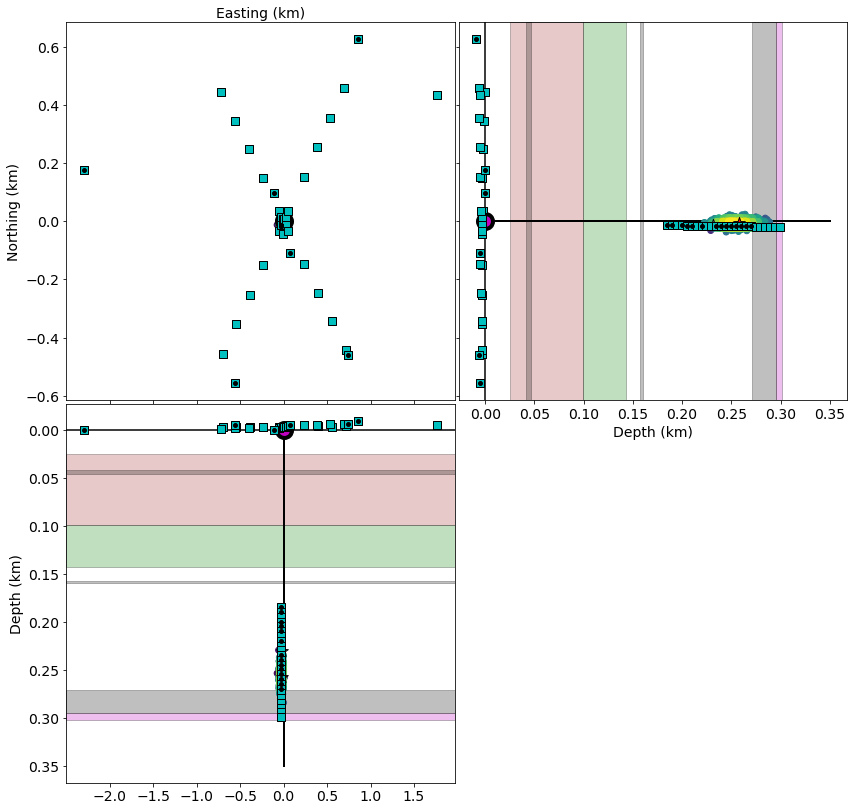

Origin
	        resource_id: ResourceIdentifier(id="smi:local/b9c9f28f-4ff1-42f4-9e54-06690ec9c81e")
	               time: UTCDateTime(2020, 3, 19, 8, 49, 6, 236000)
	          longitude: -112.120833 [uncertainty=0.000540492285157]
	           latitude: 50.4502915 [uncertainty=0.000551284144428]
	              depth: -542.9999999999999 [uncertainty=34.5]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=420.9, semi_minor_axis_length=147.0, semi_intermediate_axis_length=395.0, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->  0.100000
 1 ->  0.200000
 2 ->  0.

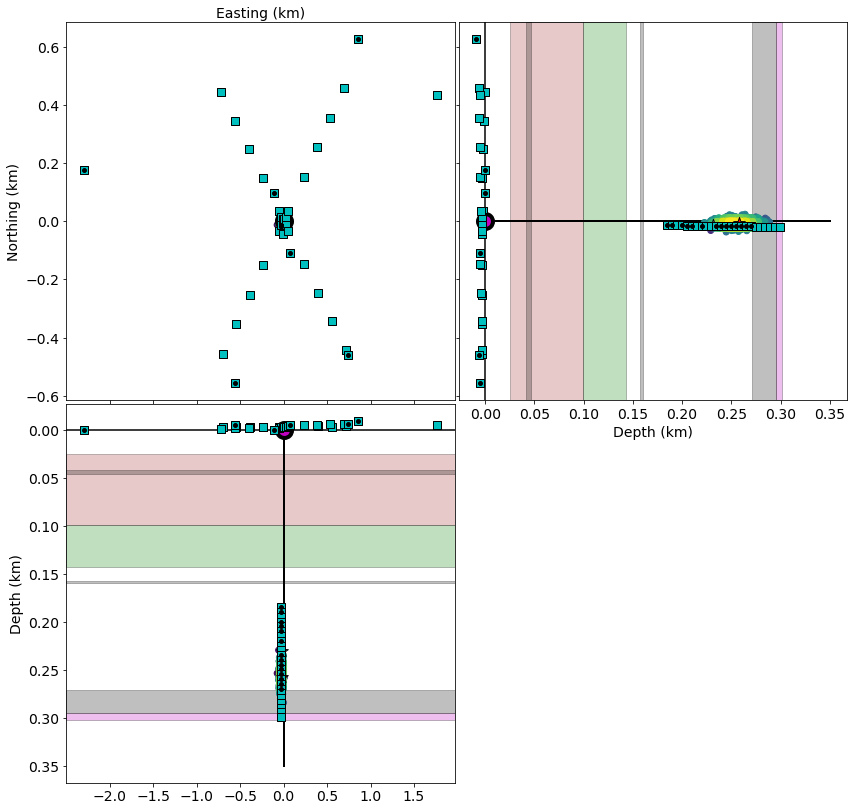

Origin
	        resource_id: ResourceIdentifier(id="smi:local/6c9169e1-9c0e-49cc-b708-a63611fd65cb")
	               time: UTCDateTime(2020, 3, 18, 12, 11, 21, 332000)
	          longitude: -112.121002 [uncertainty=0.00215027795975]
	           latitude: 50.450129700000005 [uncertainty=0.00140563967005]
	              depth: -557.0 [uncertainty=103.8]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=421.3, semi_minor_axis_length=147.2, semi_intermediate_axis_length=395.4, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->  0.100000
 1 ->  0.200000
 2 ->  0.250

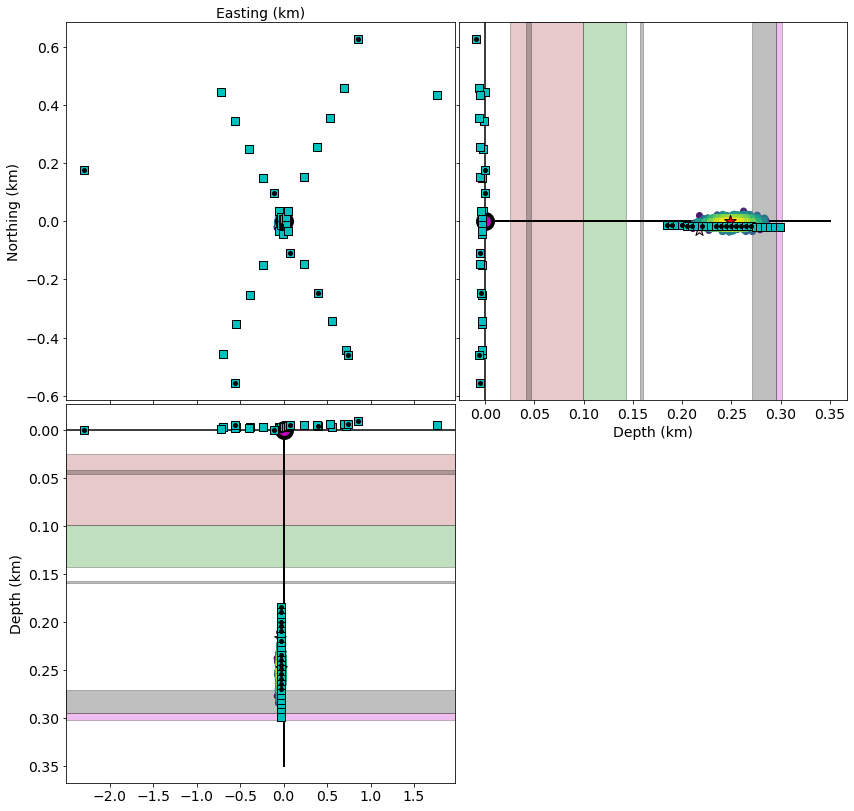

Origin
	        resource_id: ResourceIdentifier(id="smi:local/344eeb39-f166-44d5-982c-f7068a5acc6a")
	               time: UTCDateTime(2020, 3, 19, 11, 2, 43, 824000)
	          longitude: -112.120579 [uncertainty=0.000585458365453]
	           latitude: 50.4502735 [uncertainty=0.000603444797571]
	              depth: -556.0 [uncertainty=34.4]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=420.8, semi_minor_axis_length=147.0, semi_intermediate_axis_length=395.0, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->  0.100000
 1 ->  0.200000
 2 ->  0.250000
 3 -

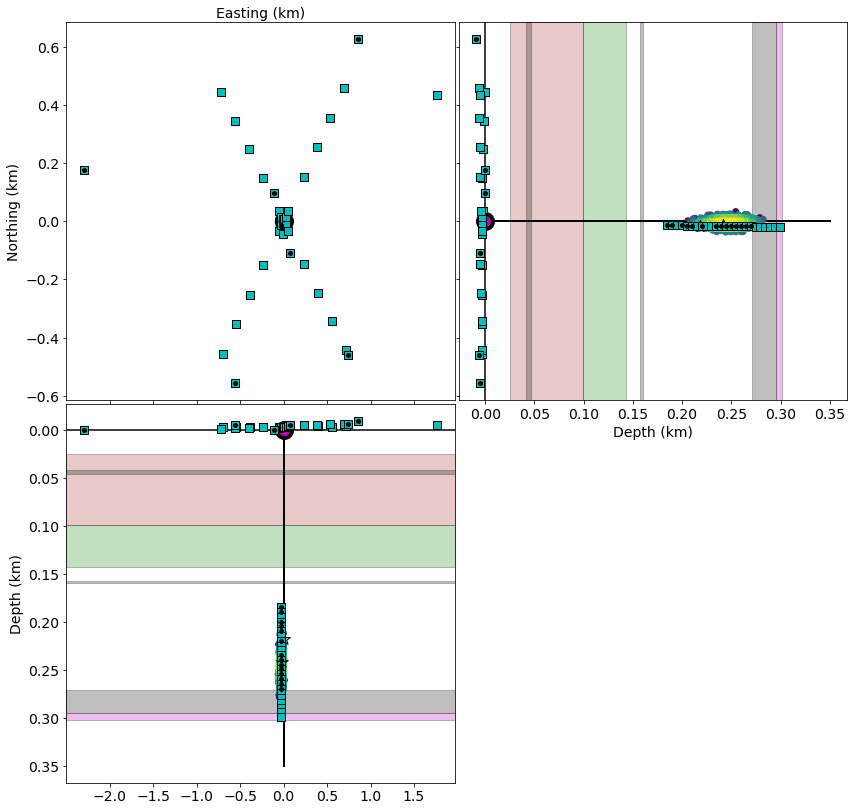

Origin
	        resource_id: ResourceIdentifier(id="smi:local/b55c98c3-26af-4e82-a11a-40d3f6363765")
	               time: UTCDateTime(2020, 3, 19, 8, 19, 6, 540000)
	          longitude: -112.120804 [uncertainty=0.000673591882833]
	           latitude: 50.4504533 [uncertainty=0.00073384643043]
	              depth: -556.0 [uncertainty=35.3]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=420.70000000000005, semi_minor_axis_length=147.0, semi_intermediate_axis_length=394.8, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->  0.100000
 1 ->  0.200000
 2 ->  0.

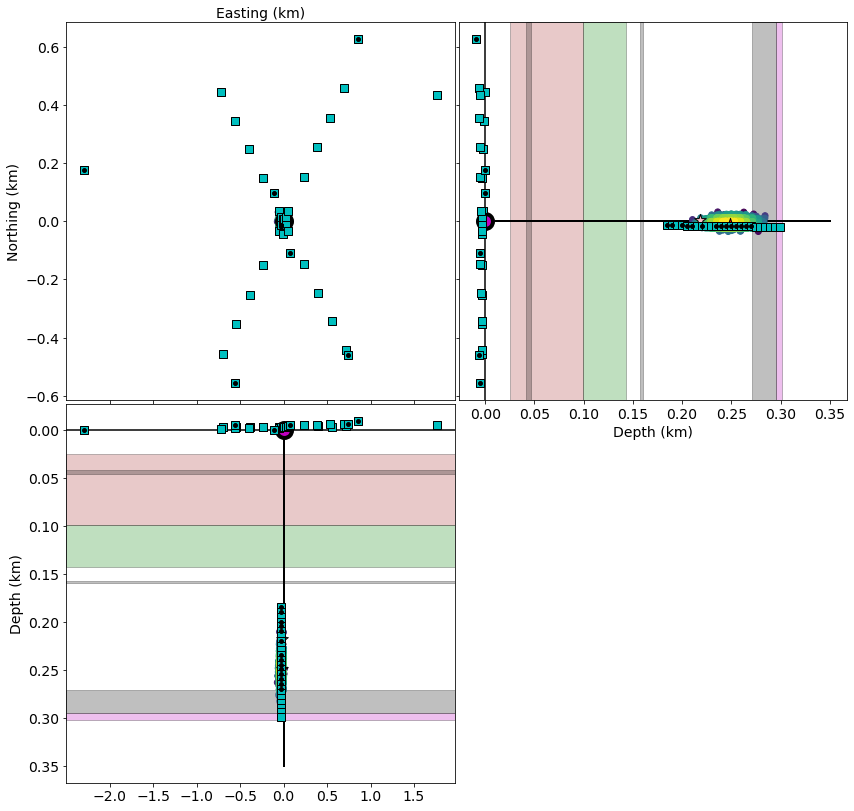

Origin
	        resource_id: ResourceIdentifier(id="smi:local/b354584c-64be-476f-ac54-6ecd8209e144")
	               time: UTCDateTime(2020, 3, 19, 9, 3, 20, 408000)
	          longitude: -112.120579 [uncertainty=0.000319259170101]
	           latitude: 50.450138700000004 [uncertainty=0.000599847511148]
	              depth: -556.0 [uncertainty=68.6]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=420.59999999999997, semi_minor_axis_length=147.0, semi_intermediate_axis_length=394.7, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->  0.100000
 1 ->  0.200000


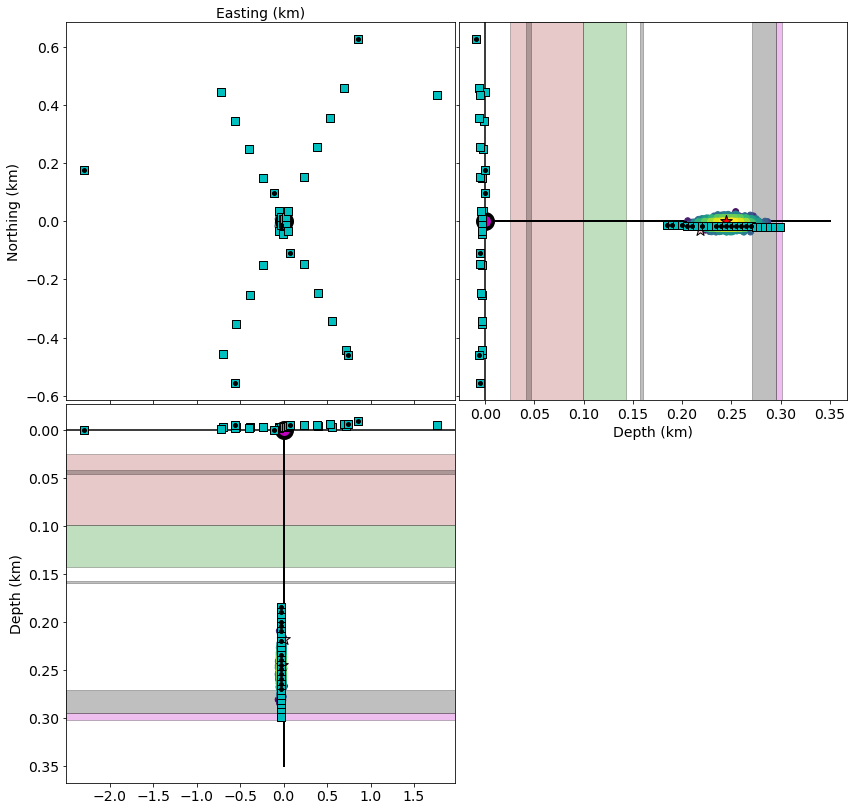

Origin
	        resource_id: ResourceIdentifier(id="smi:local/7796a7d4-445f-4b5b-acef-452fba00aac1")
	               time: UTCDateTime(2020, 3, 17, 5, 28, 50, 252000)
	          longitude: -112.12114199999999 [uncertainty=0.000818382661386]
	           latitude: 50.450174700000005 [uncertainty=0.00119339977105]
	              depth: -578.0 [uncertainty=144.9]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=421.3, semi_minor_axis_length=147.2, semi_intermediate_axis_length=395.3, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->  0.100000
 1 ->  0.200000
 2 -

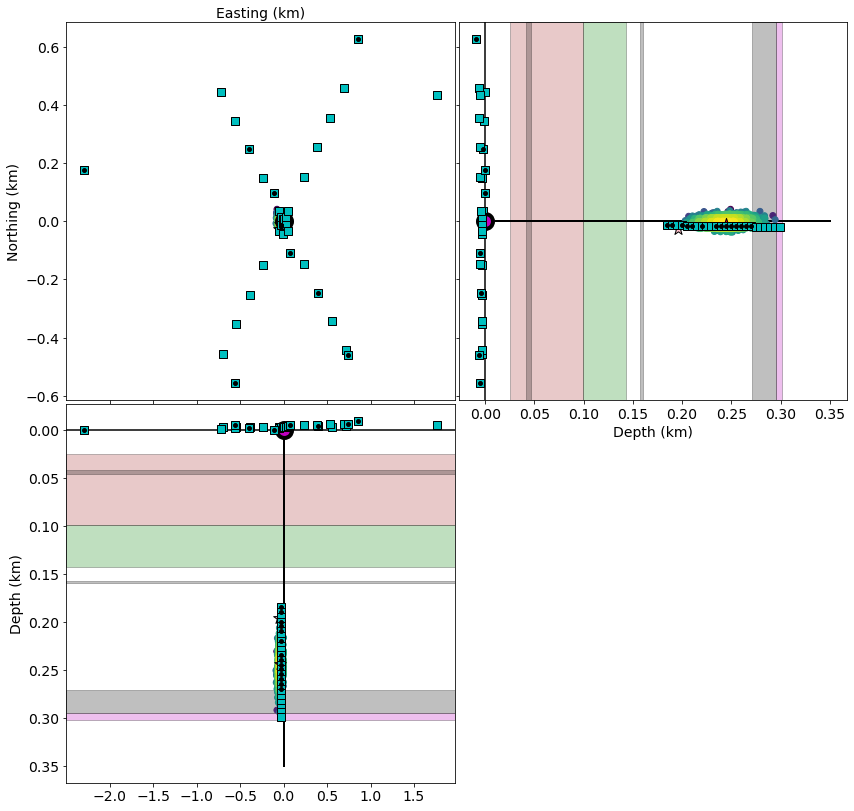

Origin
	        resource_id: ResourceIdentifier(id="smi:local/7d43341d-7710-41fc-8275-dc8902bdb834")
	               time: UTCDateTime(2020, 3, 19, 8, 17, 9, 228000)
	          longitude: -112.120833 [uncertainty=0.000317460526889]
	           latitude: 50.4502915 [uncertainty=0.000580961757423]
	              depth: -542.9999999999999 [uncertainty=65.1]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=420.70000000000005, semi_minor_axis_length=147.0, semi_intermediate_axis_length=394.9, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->  0.100000
 1 ->  0.200

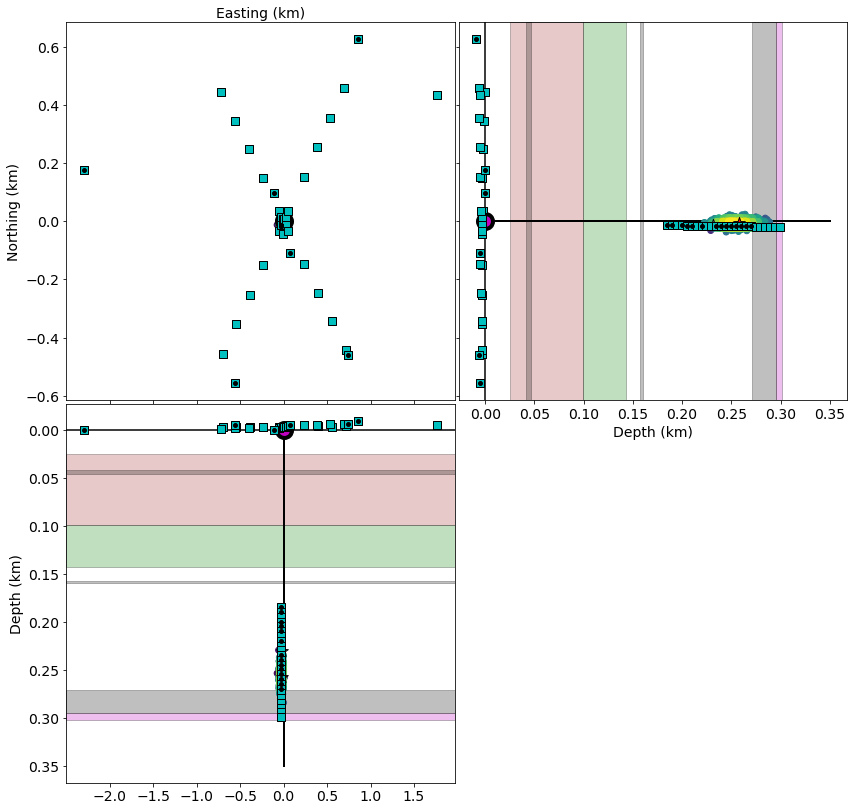

Origin
	        resource_id: ResourceIdentifier(id="smi:local/ba0bfdda-e270-4d83-b0b0-b4725bfdd62a")
	               time: UTCDateTime(2020, 3, 18, 5, 55, 54, 272000)
	          longitude: -112.121086 [uncertainty=0.000985656480087]
	           latitude: 50.4504533 [uncertainty=0.000945187007821]
	              depth: -567.0000000000001 [uncertainty=78.2]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=421.20000000000005, semi_minor_axis_length=147.2, semi_intermediate_axis_length=395.3, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->  0.100000
 1 ->  0.20

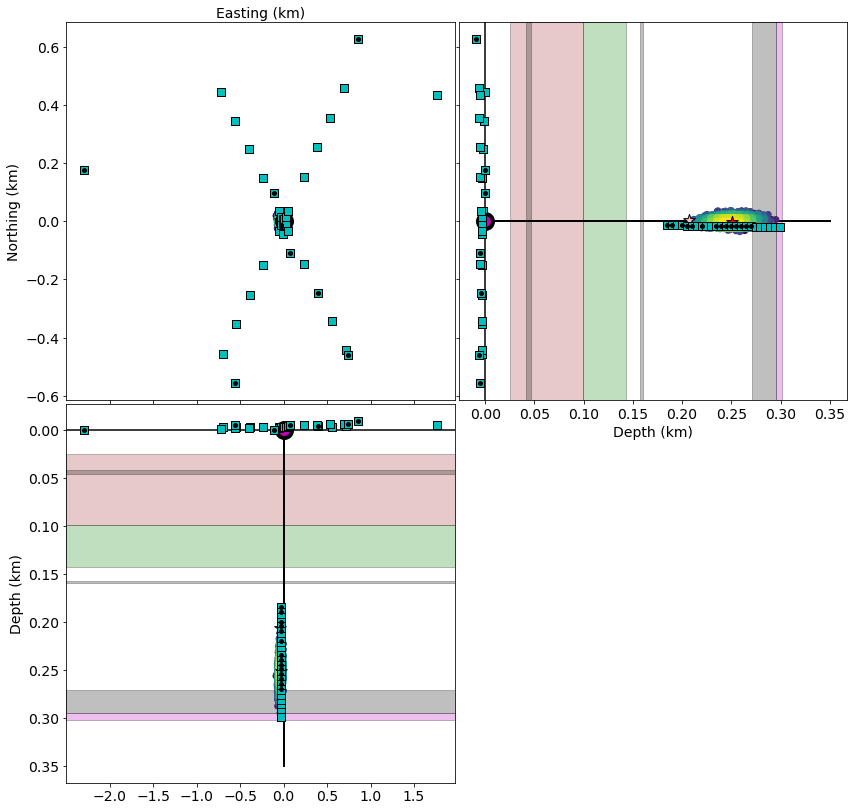

Origin
	        resource_id: ResourceIdentifier(id="smi:local/56b820df-c15b-4d82-bdb0-76e6a45b14ca")
	               time: UTCDateTime(2020, 3, 19, 16, 12, 50, 848000)
	          longitude: -112.120833 [uncertainty=0.000562975325305]
	           latitude: 50.4502825 [uncertainty=0.000553982109246]
	              depth: -544.0 [uncertainty=35.1]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=420.9, semi_minor_axis_length=147.0, semi_intermediate_axis_length=394.9, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->  0.100000
 1 ->  0.200000
 2 ->  0.250000
 3 

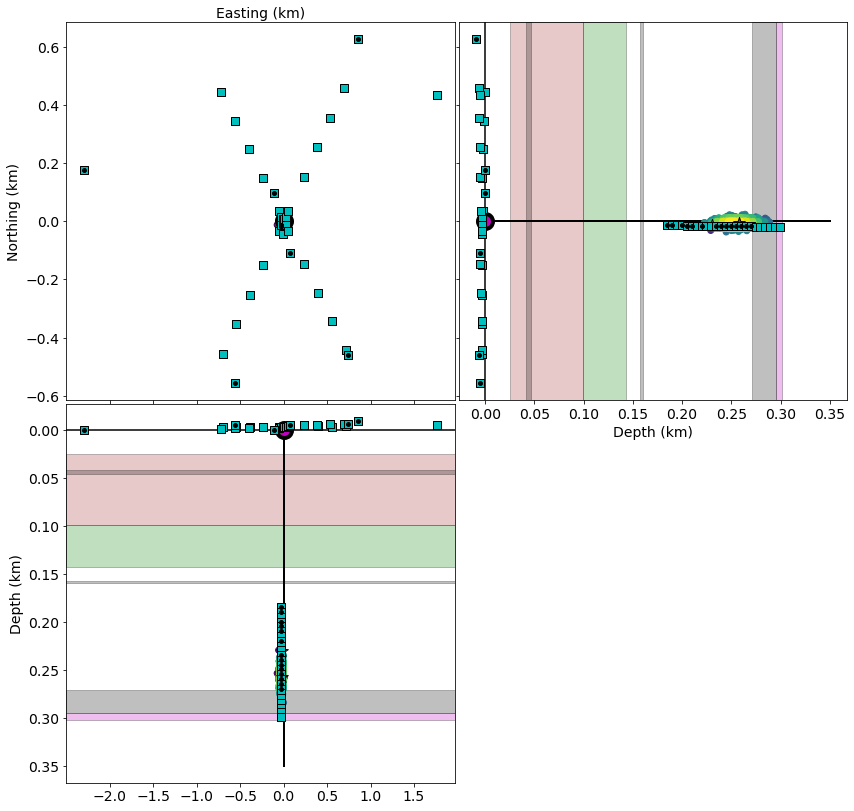

Origin
	        resource_id: ResourceIdentifier(id="smi:local/17ea96d4-a7aa-4841-b963-47cfb6a31423")
	               time: UTCDateTime(2020, 3, 19, 8, 53, 6, 336000)
	          longitude: -112.120833 [uncertainty=0.000524304496251]
	           latitude: 50.4502915 [uncertainty=0.000534197033916]
	              depth: -544.0 [uncertainty=34.7]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=420.59999999999997, semi_minor_axis_length=147.0, semi_intermediate_axis_length=394.8, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->  0.100000
 1 ->  0.200000
 2 ->  0

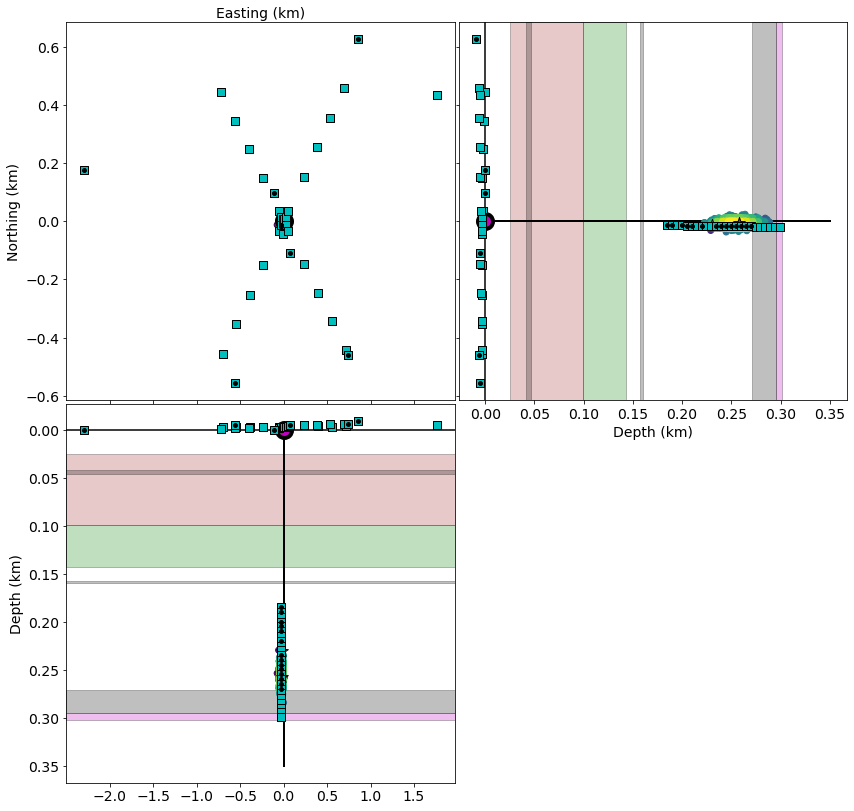

Origin
	        resource_id: ResourceIdentifier(id="smi:local/14462948-6afe-4ef2-8dda-42cb66005aff")
	               time: UTCDateTime(2020, 3, 19, 10, 39, 50, 484000)
	          longitude: -112.121086 [uncertainty=0.000638518340202]
	           latitude: 50.450138700000004 [uncertainty=0.000652008164291]
	              depth: -532.9999999999999 [uncertainty=41.2]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=421.00000000000006, semi_minor_axis_length=147.10000000000002, semi_intermediate_axis_length=395.1, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->

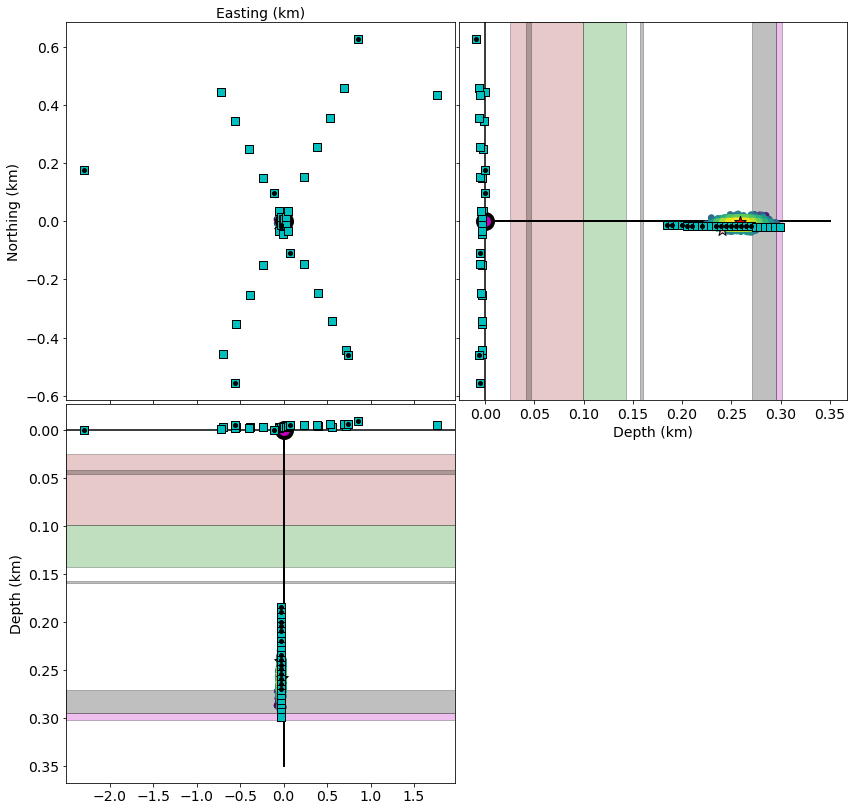

Origin
	        resource_id: ResourceIdentifier(id="smi:local/d5840b1c-dbd0-406b-8aea-6045e45e0090")
	               time: UTCDateTime(2020, 3, 19, 16, 34, 43, 992000)
	          longitude: -112.121086 [uncertainty=0.000560277360487]
	           latitude: 50.4504533 [uncertainty=0.000570169898152]
	              depth: -556.0 [uncertainty=32.5]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=421.00000000000006, semi_minor_axis_length=147.0, semi_intermediate_axis_length=395.1, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->  0.100000
 1 ->  0.200000
 2 -> 

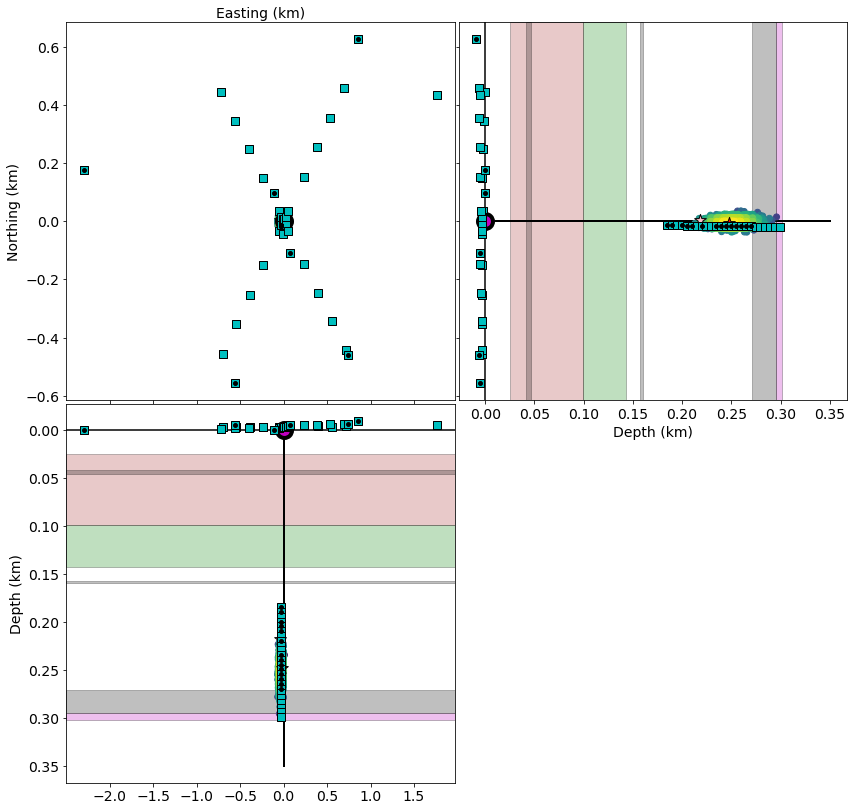

Origin
	        resource_id: ResourceIdentifier(id="smi:local/f7f7e699-eab3-4797-a5ce-420ccc7530c8")
	               time: UTCDateTime(2020, 3, 18, 3, 8, 45, 472000)
	          longitude: -112.121002 [uncertainty=0.00059714954633]
	           latitude: 50.4500398 [uncertainty=0.000977562585634]
	              depth: -542.9999999999999 [uncertainty=120.2]
	          method_id: ResourceIdentifier(id="smi:local/spline")
	        origin_type: 'hypocenter'
	 origin_uncertainty: OriginUncertainty(confidence_ellipsoid=ConfidenceEllipsoid(semi_major_axis_length=421.4, semi_minor_axis_length=147.2, semi_intermediate_axis_length=395.5, major_axis_plunge=0.0, major_axis_azimuth=0.0, major_axis_rotation=0.0), preferred_description='confidence ellipsoid')
	    evaluation_mode: 'automatic'
NLLoc (NonLinLoc v7.00.10 30Aug2020) 
GRID: {x, y, z}
  Num: {2001, 2001, 990}
  Orig: {-1, -1, 0}
  LenSide: {0.001, 0.001, 0.001}
  Type: PROB_DENSITY
NLLoc LOCQUAL2ERR:
 0 ->  0.100000
 1 ->  0.200000
 2 ->  0.

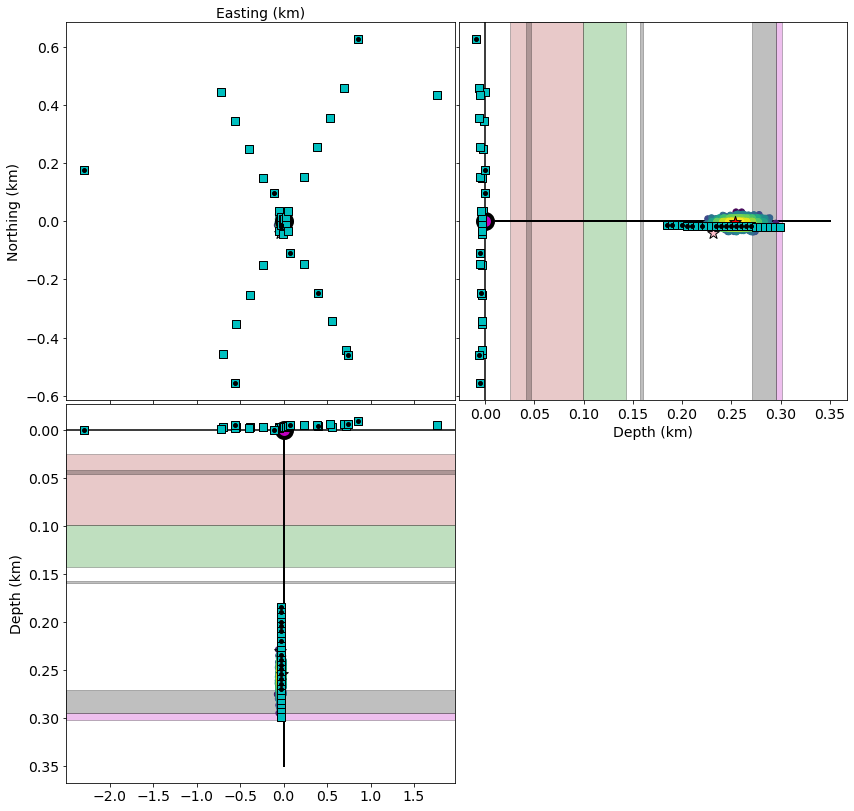

KeyboardInterrupt: 

In [71]:
import glob
import os
import obspy.core.event
import pyasdf
import obspy
from PickReview.utils import *
from PickReview.nlloc_utils import run_nonlinloc
from PickReview.plotting import plot_scatter
import logging
Logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s\t%(name)s\t%(levelname)s\t%(message)s")

from obspy.geodetics.base import gps2dist_azimuth
    
flist = glob.glob("/home/genevieve/research/quakemigrate/cami/dets_fromscamp_h5/2020031*.h5")

for filename in flist:
    # Open H5 file and extract event and stream
    ds = pyasdf.ASDFDataSet(filename=filename)
    event = ds.events[0].copy()
    stream = obspy.Stream()
    for id in ds.waveforms.list():
        stream += ds.waveforms[id]["raw_recording"]
    del ds

    # Criterion for analysis
    reflat = 50.4502915
    reflon = -112.120833
    refdepth = -543
    tup = gps2dist_azimuth(event.preferred_origin().latitude, event.preferred_origin().longitude, reflat, reflon)
    distance = np.sqrt(tup[0]**2 + (event.preferred_origin().depth - refdepth)**2)
    if distance > 50:
        continue
    print(event.preferred_origin())

    picks, _ = fix_picks_ids(event, stream, method="modelled")
    markers = picks2markers(picks, event=event, phase=True, kinds=(1, 2))
    markers_out = markers

    run_dir = "/home/genevieve/research/PickReview/NonLinLoc/temp_dir"
    for f in glob.glob(os.path.join(run_dir, "*")):
        os.remove(f)
    fname = os.path.join(run_dir, "phases.obs")
    write_obs(phase_markers=markers_out, fname=fname)

    # RUN NLLOC
    run_nonlinloc(fname)

    # PLOT
    
    previous_origin = event.preferred_origin() 
    previous_origin.depth += 774
    plot_scatter(hypfile="/home/genevieve/research/PickReview/NonLinLoc/temp_dir/last.hyp",
                previous_origin=previous_origin)

In [67]:
# # PLOT
# from PickReview.plotting import *
# previous_origin = event.preferred_origin() 
# previous_origin.depth += 774
# plot_scatter(hypfile="/home/genevieve/research/PickReview/NonLinLoc/temp_dir/last.hyp",
#             previous_origin=previous_origin)